# Molecular dynamics in Python: Lists upon lists

In this workshop you'll write a molecular dynamics simulator of a 1-dimensional system. We'll profile the code performance and do some very basic analysis of the results.

If you feel you need a refresher or reference to keep up with all the Python being thrown around, there is a short summary in `00_basics_of_python.ipynb`.

If you're having trouble with an error message, Googling the message is usually the fastest way to a solution. Results from StackOverflow are particularly helpful.


There's a lot of words here about molecular dynamics, but that is mostly window-dressing for the Python. Those of you with Jupyter Nbextensions installed and Collapsible Headings turned on will be able to hide or show explanations as desired. The colour-coding here is as follows:

<div class="alert alert-block alert-warning">&#x1F4DC;  &nbsp; Molecular dynamics explanation &nbsp; &#x1F4DC;</div>

<div class="alert alert-block alert-success">&#x1F40D;  &nbsp; Explanation of previous Python &nbsp; &#x1F40D; </div>

<div class="alert alert-block alert-info"><b>To do</b></div>

<div class="alert alert-block alert-info"><b><div class="alert alert-block alert-warning"> Python Tip </div></b></div>

## Background

Molecular dynamics (MD) is a branch of computational chemistry that simulates the movements of atoms to study chemical interactions over time at the atomic level. These simulations are calculated by solving Newton's equations of motion for discrete steps in time. Forces and potential energies are calculated using interatomic potentials (as in this workshop) or force fields. 

## Lennard-Jones Potential

The code here uses the Lennard-Jones potential below to model inter-particle interactions, where $r_{ij}$ represents the distance between atom $i$ and atom $j$.

$$
\begin{equation}
E^{LJ}(r_{ij}) = 4\epsilon\big[\big(\frac{\sigma}{r_{ij}}\big)^{12}-\big(\frac{\sigma}{r_{ij}}\big)^{6}\big]
\end{equation}$$

<img src="files/lj_graph.png" width="400px">

We use dimensionless units throughout the code to  simplify the equation. Redefining the energy $E^{LJ}$ in terms of length $\sigma$, energy $\epsilon$, and mass $m$ gives us:
$$
\begin{equation}
E^{LJ}(r_{ij}) = 4\big[r^{12} - r^6\big]
\end{equation}$$
</div>

with these physical properties:

| Property | Symbol | Reduced form |
| --- | --- | --- |
| Distance | $r$ | $r/\sigma$ |
|   Time   | $t$ | $t(\epsilon/m \sigma^2)^{\frac{1}{2}}$ |
| Temperature | $T$ | $k_BT/\epsilon$ |
| Force | $f$ | $f\sigma/\epsilon$ |
| Energy | $E$ | $E/\epsilon$ |
| Pressure | $P$ | $P\sigma^3/\epsilon$ |
| Density | $\rho$ | $\sigma^3\rho/m$ |

$k_B$ represents the Boltzmann constant, $1.38 x 10^{-23} m^2 kg s^{-2} K^{-1}$.

## Python

### Class definition

The class `MD1D` is defined for you below. Several properties are defined in `__init__`, such as the length of the system. This is required as MD is still a slow process and only a finite system can be simulated in a finite cell. An infinite system is approximated by tiling identical cells, as in the image below. The computer only keeps track of the central one in bold, and particle interactions are only computed between the closest image. 



<img src="files/pbc_labelled.png" width="500px">

#### &#x1F4DC;  &nbsp; Cutoffs &nbsp; &#x1F4DC;

<div>
Calculation of interactions between nonbonded particles is by far the most time-consuming part of molecular dynamics, as it scales at $\mathcal{O}(N^2)$ for $N$ particles. One method to reduce calculations is approximate  all interactions beyond a certain distance cutoff. Here the approximation is that interactions beyond the cutoff contribute nothing to the forces and energies of each particle. <i>Currently the cutoff distance is set to 18, half the cell-length, so all interactions are computed.</i>

The squared cutoff-distance is also defined below. This is because when 3D distances are computed they involve square-rooting, an expensive process. It is common to simply compare the squares of distances.
$$ d(\vec{i},\vec{j}) = \sqrt{(i_x-j_x)^2 + (i_y-j_y)^2 + (i_z-j_z)^2}$$

Finally, a cutoff energy is given. `cutoff_energy` is the potential energy at the cutoff distance. To avoid discontinuities, the Lennard-Jones potential is shifted up by subtracting the `cutoff_energy`. This truncates the potential to 0 at the cutoff distance.

#### <div class="alert alert-block alert-info"><b>Create lists to hold the temperatures, potential energies, and total energies. Make `cutoff_dist` a keyword argument that you can change when you create an instance of `MD1D`.</b></div><a class='tocSkip'>

In [11]:
class MD1D:  # Defines a class
    n_dims = 1
    def __init__(self, n_steps, x_length = 36.0, n_particles=36):  # Defines instance method __init__
        self.n_particles = n_particles  # Number of particles
        self.x_length = x_length  # Length of 1D box
        self.lattice = self.x_length/self.n_particles  # Spacing
        
        self.time_step = 0.01  # Integration time step
        self.n_steps = n_steps  # Number of steps to take
        
        self.cutoff_dist = 18.0  # Distance cutoff for computing interactions
        self.cutoff_sq = self.cutoff_dist ** 2  # Squared cutoff
        self.cutoff_energy =  4 * (self.cutoff_dist ** -12 - self.cutoff_dist ** -6)  # Cutoff energy at r=cutoff_dist
        
        self.temperature = 0.728
        
        # Set up lists as empty property containers
        self.x_coords = []  # Empty list of length 0
        self.velocities = []
        self.forces = []
        # set up lists for properties below
        self.temperatures = []
        self.energies_potential = []
        self.energies_total = []
    
    

####  &#x1F40D;  &nbsp; What's happening here? &nbsp; &#x1F40D; 

<div class="alert alert-block alert-success">

The cell above defines the class `MD1D`. Almost everything in Python is an object, and a class is like a template for objects, or instances, of that class. 

- `__init__` is the first method called when a new object is created, and it is generally defined to assign all the required attributes of an object needed for operation. Here we are assigning properties of our system that will remain unchanged, and setting up empty lists to track the evolution of the system throughout simulation.


- `self` is the first argument of all instance methods defined in the class. When calling instance methods from an object, it is left out since the object is assumed to be `self`. If I wanted to call `__init__` again, for example, it would look like this:
```
    my_md = MD1D()
    my_md.__init__(20, n_particles=100)
```


- `n_steps` is an argument passed to the function when it's called. It *must* be passed each time, in the correct position (ie first), or you will get an error. `n_particles`, however, is a 'keyword argument'. Its default is 36 and it doesn't matter which order you write your keyword arguments in, so long as you use the `kwarg=value` syntax instead of just `value`.


- `**` means to the power of. `x ** y` will calculate $x^y$.
</div>

#### <div class="alert alert-block alert-info"><b>Create an instance of `MD1D` below and assign it to a variable.</b></div>

In [3]:
sim1d = MD1D(100, n_particles=36)

### Set up initial state

Next, you should define the function `setup_system` below where you will set up your simulation system at time=0. This involves the following steps for each particle:

1. Generating initial coordinates
2. Generating an initial force (0.0 to start off)
3. Generating an initial velocity (random to start with)
4. Scaling your random velocities to match your desired temperature `self.temperature`
5. Generating 'previous' coordinates for each particle for time=`-self.time_step` based on those scaled velocities

Steps 1-3 have been done for you, but you will have to collect the properties in lists using methods such as my_`list.append(item)`. You will have to calculate a scale factor for Step 4 in the function `get_scale_factor()` before you can do Steps 4 and 5. Finally, you'll need to append the generated properties to the `md` object.


#### &#x1F4DC;  &nbsp; `get_scale_factor()`  &nbsp; &#x1F4DC;


As the initial velocity distribution over your particles is random, we need to scale it to achieve thermal equilibrium using the `scale_factor` variable you will define in the code. In thermal equilibrium, the instantaneous temperature $T(t)$ at time $t$ is related to the velocity $v$ as below. 
    
$$ k_BT(t) = \sum\limits_{i=1}^{N} \frac{mv^2_{\alpha, i}(t)}{N} $$

As we have redefined the system in simplified units and the system is 1-dimensional, this can be reduced to:

$$T(t) = \sum\limits_{i=1}^{N} \frac{v^2_{i}(t)}{N}$$

If we break down the velocity $v$ into the random velocity $u$ and `scale_factor` $s$ for time $t=0$:

$$\begin{eqnarray}
v &=& u_is \\
T_0 &=& s^2\sum\limits_{i=1}^{N} \frac{u_i^2}{N}
\end{eqnarray}$$

In the code, `avg_vsum_sq` represents the sum of squared velocities over the number of particles (which we will shorten to $V_\sigma$):

$$\begin{eqnarray}
\sum\limits_{i=1}^{N} \frac{u_i^2}{N} &=& V_\sigma\\
T_0 &=& s^2 V_\sigma\\
s &=& \sqrt{\frac{T_0}{V_\sigma}}
\end{eqnarray}$$

Therefore your `get_scale_factor` function should use two terms: average sum of squared velocities `avg_vsum_sq`, and the desired temperature at time 0 `self.temperature`.

</div>

#### &#x1F4DC;  &nbsp; Previous positions  &nbsp; &#x1F4DC;

In this simulation we are solving Newton's equations numerically with discrete time-steps. The Verlet method uses forces $F=ma$ to calculate positions at the next time-step. Velocities are calculated as midpoints between positions, i.e.
$$v_i = \frac{x_{i+1} - x_{i-1}}{2}$$. 

Therefore to calculate a velocity at time=0, we need to walk one step back into negative time and calculate the previous positions of those atoms at those velocities. This is done using the less accurate Euler method. 

The equation is below, where $x$ is the coordinate and $v$ represents the velocity. $\Delta t$ is the time difference between the two steps, i.e. the time_step.
    $$x_{prev} = x_{now} - v_{now}*\Delta t$$


Below is an image of what the `md.x_coords` list will look like when the positions for all the time steps have been added.
<img src="files/velocities.png" width="500px">



#### <div class="alert alert-block alert-info"><b>Write a function that returns the scale factor as defined above.</b></div>

In [4]:
def get_scale_factor(avg_vsum_sq, temperature):
    return (temperature / avg_vsum_sq) ** 0.5

<div class="alert alert-block alert-info">
<b>
    1. Use get_x_position to generate atom positions.<br>
    2. Add each atom position, force and velocity to their respective lists.<br>
    3. Calculate the previous position.<br>
    4. Add the lists for this time, ie time=0, to the md object.<br>
</b></div>

In [21]:
def get_x_position(md, index):
    """ Places each atom at points on the lattice according to the index """
    position = (index+0.5) * md.lattice
    return position

In [7]:
import random

def setup_system(md):
        """Initialise system properties at time=0."""
        
        # Initialise empty properties and containers
        vsum = 0.0  # sum of velocities
        vsum_sq = 0.0  # sum of squared velocities
        
        x_coords = []  # new list
        prev_x_coords = []
        forces = []
        velocities = []
        
        # Add particles, forces, and velocities
        for i in range(md.n_particles): # for each particle
            print("Generating position, force and velocity for particle {index}".format(index=i))
            i_x_pos = get_x_position(md, i)
            i_force = 0.0 # starting off without force
            i_vel = random.random()-0.5 # random number in range [-0.5, 0.5]
            # append each of the above properties to their respective containers
            # e.g.
            # x_coords.append(i_x_pos)
            x_coords.append(i_x_pos)
            forces.append(i_force)
            velocities.append(i_vel)
            
            vsum += i_vel # x+=y is equivalent to x = x+y
            vsum_sq += i_vel ** 2 # x**y is equivalent to x to the power of y
        
        avg_vsum = vsum/md.n_particles
        avg_vsum_sq = vsum_sq/md.n_particles
        
        # Determine scale factor required for velocities to reach specified temperature
        scale_factor = get_scale_factor(avg_vsum_sq, md.temperature)
        
        # Rescale velocities and generate previous x coordinates 
        for i in range(md.n_particles):
            velocities[i] = (velocities[i]-avg_vsum) * scale_factor
            previous_x = x_coords[i] - velocities[i] * md.time_step  # Generate this!
            prev_x_coords.append(previous_x)
        
        # add temporary lists to main lists
        md.x_coords.append(prev_x_coords)
        md.x_coords.append(x_coords)
        # add forces and velocities to main md object!

####  &#x1F40D;  &nbsp; What's happening here? &nbsp; &#x1F40D;

<div class="alert alert-block alert-success">

The cell above defines a function to operate on your `MD1D` object. Normally this would be defined within the `class MD1D` code block, with `self` replacing `md` as the first argument, but this workshop has pulled it out for convenience.

In the first line we import the module `random`. `import xx` will import a module called `xx` whose methods and classes you can access with `xx.method` or `xx.class`. Here we are using a function, `random()`, that has been defined in the library `random`. It's called in the code with `random.random()`.

</div>

#### &nbsp;
<div class="alert alert-block alert-info">
    <b>Call setup_system on your instance of `MD1D` and check that: <ul>
        <li> the velocities and forces lists are 1 element long
        <li> the x_coords list is 2 elements long
        <li> the last element of the x_coords list is a list of positions that are evenly spaced along your cell
 
 </b>
 <div class="alert alert-block alert-warning">
    
   **Tip**
   
   `len(object)` will return the length of objects that conceivably have lengths, e.g. strings, lists, arrays. `x[y]` will return the y+1th element of x. In Python, indexing starts at 0 so `x[0]` returns the first item.
    </div>
        </div>

### Calculating energies and forces

The function `get_forces` is responsible for calculating the force between each particle pair within your `self.cutoff_dist` cutoff, and the total energy of the system at the time. The end result is:

1. a list of forces for each particle that accounts for the effect of every other paired particle 
2. a total energy that is the sum of the energy for every interacting pair of particles.


For a Lennard-Jones system in reduced units, the potential energy $E_{LJ}$ can be defined as:

$$
\begin{equation}
E^{LJ}(r_{ij}) = 4\big[r^{12} - r^6\big]
\end{equation}$$

and the force $f_x$ is defined as:

$$
f_x(r) = \frac{48x}{r^2}\big(\frac{1}{r^{12}}-0.5\frac{1}{r^6}\big)
$$


#### <div class="alert alert-block alert-info"><b>Using the equation above, write functions to calculate the energy and force between two atoms as a function of distance.</b></div>

In [8]:
def calculate_energy(distance):
    d6_inv = 1/(distance ** 6)
    return 4 * d6_inv * (d6_inv - 1)

In [9]:
def calculate_force(distance):
    d2_inv = 1/(distance ** 2)
    d6_inv = d2_inv ** 3
    return 48 * d2_inv * d6_inv * (d6_inv - 0.5)

In [10]:
def get_forces(md):
    """Calculating energy and force"""
    # Initialise empty variables
    energy_sum = 0.0
    forces = []
    for i in range(md.n_particles):
        forces.append(0.0)

    # current properties
    x_coords = md.x_coords[-1] # x[-1] gets the last element in x

    for i in range(md.n_particles-1): # for every particle except the last
        for j in range(i+1, md.n_particles): # for every particle from i onwards
            # distance between atoms i and j
            distance = x_coords[i] - x_coords[j]
            n_cells = md.x_length * round(distance/md.x_length)
            distance -= n_cells #periodic boundary conditions

            if distance < md.cutoff_dist:
                energy = calculate_energy(distance)
                energy_sum += energy - md.cutoff_energy
                
                force = calculate_force(distance)
                scaled = force * distance
                forces[i] += scaled
                forces[j] -= scaled
                
    md.energies_potential.append(energy_sum)
    md.forces.append(forces)

#### <div class="alert alert-block alert-info"><b>Run get_forces on your `MD1D` instance and check that there are no errors.</b></div>

#### &nbsp;
<div class="alert alert-block alert-info">


<b>Why do you think we add 0.0 to the `forces` list to start off with instead of just appending? Try commenting that `for` block out and running it again.
    </b>
<div class="alert alert-block alert-warning">
    
   **Tip**
   
   `#` is the comment character in Python. Jupyter has a keyboard shortcut, too. `ctrl+/` will toggle comments for the line your cursor is in. If you have highlighted a block of code, it will toggle comments for that entire block.  
    </div></div>

### Integrating equations of motion

Now that the forces have been computed, we can integrate the equations of motion. 

The estimate of the position at the next time-step is calculated from the current properties below, where $f(t)$ represents the force at time $t$. $t + \Delta t$ and $t - \Delta t$ represent the next and previous time-steps respectively. 
$$
x(t + \Delta t) \approx 2x(t) - x(t - \Delta t) + f(t) \Delta t^2
$$

The velocity of the current time-step can therefore be calculated:
$$
v(t) = \frac{x(t + \Delta t) - x(t - \Delta t)}{2 \Delta t}
$$

We use this to calculate the instantaneous temperature by the equation above:

$$T(t) = \sum\limits_{i=1}^{N} \frac{v^2_{i}(t)}{N}$$


We would also like to calculate the total energy per particle. This energy is a sum of the potential energy and kinetic energy. The potential energy was calculated in the `get_forces` function using the Lennard-Jones potential. The kinetic energy is calculated with $\frac{1}{2}mv^2$. In reduced units, this simplifies to $\frac{1}{2}v^2$.


Below is a picture of what your `md.x_coords` list should look like after all the time-steps have been completed. `md.x_coords` should be `md.n_steps + 1` elements long, and each element should also be a list of `md.n_particles` length. Each element in these sub-lists should be a float.

<img src="files/velocities.png" width="500px">

#### &#x1F4DC;  &nbsp; Background behind equations &nbsp; &#x1F4DC;

The Taylor expansion of the particle coordinate at time $t$ gives:
    
$$
\begin{eqnarray}
    x(t + \Delta t) &=& x(t) + \dot x(t) \Delta t + \ddot x(t)\frac{\Delta t^2}{2!} + \dddot x(t)\frac{\Delta t^3}{3!} + \mathcal{O}(\Delta t^4) \\
    x(t - \Delta t) &=& x(t) - \dot x(t) \Delta t + \ddot x(t)\frac{\Delta t^2}{2!} - \dddot x(t)\frac{\Delta t^3}{3!} + \mathcal{O}(\Delta t^4)
\end{eqnarray}
$$
    
   Adding those equations together and substituting acceleration $a(t) = \ddot x(t)$ results in this:
   
   
   $$
   x(t + \Delta t) + x(t - \Delta t) = 2x(t) + a(t)\Delta t^2 + \mathcal{O}(\Delta t^4)
   $$
   
   Given that mass $m$ vanishes in reduced units, the force $F=ma$ reduces to $F=a$. The remainder term $\mathcal{O}(\Delta t^4)$ is dropped as the error. Therefore:
   
$$
\begin{eqnarray}
x(t + \Delta t) + x(t - \Delta t) &=& 2x(t) + f(t)\Delta t^2 \\
x(t + \Delta t) &\approx& 2x(t) - x(t - \Delta t) + f(t) \Delta t^2
\end{eqnarray}
$$



This method uses forces to compute the new positions. The velocity at time $t$ is approximated when positions at time-steps before and after $t$ are known, using the equation in the main block above. Known as the Verlet algorithm, this approach is more accurate than the Euler method of using the velocity at time $t$ to determine the position at time $t + \Delta t$.


#### <div class="alert alert-block alert-info"><b>Using the equations above, write a function to integrate the equations of motion.</b></div>

In [12]:
def next_position(current_x, previous_x, time_step, current_force):
    x = 2 * current_x - previous_x + time_step * time_step * current_force
    return x

def current_velocity(next_x, previous_x, time_step):
    v = (next_x - previous_x) / (2 * time_step)
    return v

def instant_temperature(vsum_sq, n_particles):
    return vsum_sq / n_particles

def total_energy_per_particle(energy, vsum_sq, n_particles):
    total_energy = energy + (0.5 * vsum_sq)
    return total_energy / n_particles

In [13]:
def integrate(md):
    """Integrate equations of motion"""
    
    # Initialise empty variables
    vsum_sq = 0.0 # sum of squared velocities
    # create an empty list of x coordinates for next time step
    x_next = []
    
    # current properties
    # x[-1] returns the last element in x
    forces = md.forces[-1]  # most recent element in md.forces
    x_now = md.x_coords[-1]  # last element in md.x_coords
    x_prev = md.x_coords[-2]  # second last element in md.x_coords
    energy_now = md.energies_potential[-1]  # last element in md.energies_potential
    
    # for every particle, calculate 
    # the next position with next_position() and 
    # the current velocity with current_velocity().
    # Add this velocity to vsum_sq.
    # Keep the next_x position in the list you created
    for i in range(md.n_particles):
        x = next_position(x_now[i], x_prev[i], md.time_step, forces[i])
        x_next.append(x)
        v = current_velocity(x, x_prev[i], md.time_step)
        vsum_sq += (v ** 2)
    
    # when you've finished the loop, append the list 
    # of next positions to md.x_coords
    md.x_coords.append(x_next)
    
    # calculate the instantaneous temperature and append 
    # it to md.temperatures
    temp = instant_temperature(vsum_sq, md.n_particles)
    md.temperatures.append(temp)
    
    # get the total energy per particle and append 
    # it to md.energies_total
    en = total_energy_per_particle(energy_now, vsum_sq, md.n_particles)
    print("  --- Energy: {en} ---".format(en=en))
    md.energies_total.append(en)
    

### Viewing

<div class="alert alert-block alert-info"><b>
    Now you need to write out your coordinates to a file that's readable by other software. Use string formatting to write a file that looks like the example 'example.xyz' in the folder.</b>
<div class="alert alert-block alert-warning">
    
   **Tip**
   
   `range(x)` returns an iterable of numbers `(0, 1, 2, ... x-1)`. 
   
   File I/O is usually handled within context managers that automatically close the file when you're done. To read:
   
   ```
       with open(filename, 'r') as f:
           contents = f.read()
   ```
   
   To write:
   ```
       with open(filename, 'w') as f:
           f.write(contents)
   ```
   
   `'\n'` prints a newline, i.e. moves to the next line in the file. I would expect `f.write("e\nb  c\n  d")` to write:
   
   ```
   e
   b  c
     d
   ```
</div>
</div>

In [25]:
def write_coordinates(md):
    # x[y:] take all elements in x from index y onwards
    x_coords = md.x_coords[1:] # remove first list of positions at negative time
    with open('example1d.xyz', 'w') as f: # f is the open file object
        # for every step from 0 to md.n_steps inclusive
        # Write the number of particles and a newline
        # And the time
        for t in range(md.n_steps+1): 
            time = t * md.time_step
            f.write("{N}\n".format(N=md.n_particles))
            f.write("time {time}\n".format(time=time))
            for i in range(md.n_particles):
                f.write("C {x} 0.0 0.0\n".format(x=md.x_coords[t][i]))
    print("Wrote coordinates to example1d.xyz")

The `view()` function below just lets you view your coordinate file as an animation.

In [57]:
from ase.visualize import view
from ase.io import read as ase_read

def watch(md):
    atoms = ase_read('example1d.xyz', index=':')
    return view(atoms)

### Putting it all together

<div class="alert alert-block alert-info">
    <b>Write a main function that strings it all together.</b></div>

In [44]:
def main():
    # setup the system
    # for every time_step in md.n_steps, 
    # print out which step it is (so you 
    # can track your progress). Then 
    # calculate forces and integrate the 
    # equations of motion.
    # Finally, write the coordinates to a file.
    md = MD1D(100)
    setup_system(md)
    for t in range(md.n_steps):
        print("Calculating time step ", t)
        get_forces(md)
        integrate(md)
    write_coordinates(md)
    print("Done!")
    return md

## Run the code

In [45]:
sim1d = main()

Generating position, force and velocity for particle 0
Generating position, force and velocity for particle 1
Generating position, force and velocity for particle 2
Generating position, force and velocity for particle 3
Generating position, force and velocity for particle 4
Generating position, force and velocity for particle 5
Generating position, force and velocity for particle 6
Generating position, force and velocity for particle 7
Generating position, force and velocity for particle 8
Generating position, force and velocity for particle 9
Generating position, force and velocity for particle 10
Generating position, force and velocity for particle 11
Generating position, force and velocity for particle 12
Generating position, force and velocity for particle 13
Generating position, force and velocity for particle 14
Generating position, force and velocity for particle 15
Generating position, force and velocity for particle 16
Generating position, force and velocity for particle 17
Ge

In [33]:
watch(sim1d)

### Timing the code

<div class="alert alert-block alert-info"><b>How long does the simulation take? Profile it with the magic command `%prun`. Which step is the least efficient? Does changing the cutoff distance help?</div>

In [58]:
%prun main()

Generating position, force and velocity for particle 0
Generating position, force and velocity for particle 1
Generating position, force and velocity for particle 2
Generating position, force and velocity for particle 3
Generating position, force and velocity for particle 4
Generating position, force and velocity for particle 5
Generating position, force and velocity for particle 6
Generating position, force and velocity for particle 7
Generating position, force and velocity for particle 8
Generating position, force and velocity for particle 9
Generating position, force and velocity for particle 10
Generating position, force and velocity for particle 11
Generating position, force and velocity for particle 12
Generating position, force and velocity for particle 13
Generating position, force and velocity for particle 14
Generating position, force and velocity for particle 15
Generating position, force and velocity for particle 16
Generating position, force and velocity for particle 17
Ge

<div class="alert alert-block alert-info"><b>How much memory is Jupyter using during the simulation? Load the `memory_profiler` extension and use `%memit` to view the peak memory consumption.

In [59]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [60]:
%memit main()

Generating position, force and velocity for particle 0
Generating position, force and velocity for particle 1
Generating position, force and velocity for particle 2
Generating position, force and velocity for particle 3
Generating position, force and velocity for particle 4
Generating position, force and velocity for particle 5
Generating position, force and velocity for particle 6
Generating position, force and velocity for particle 7
Generating position, force and velocity for particle 8
Generating position, force and velocity for particle 9
Generating position, force and velocity for particle 10
Generating position, force and velocity for particle 11
Generating position, force and velocity for particle 12
Generating position, force and velocity for particle 13
Generating position, force and velocity for particle 14
Generating position, force and velocity for particle 15
Generating position, force and velocity for particle 16
Generating position, force and velocity for particle 17
Ge

Generating position, force and velocity for particle 0
Generating position, force and velocity for particle 1
Generating position, force and velocity for particle 2
Generating position, force and velocity for particle 3
Generating position, force and velocity for particle 4
Generating position, force and velocity for particle 5
Generating position, force and velocity for particle 6
Generating position, force and velocity for particle 7
Generating position, force and velocity for particle 8
Generating position, force and velocity for particle 9
Generating position, force and velocity for particle 10
Generating position, force and velocity for particle 11
Generating position, force and velocity for particle 12
Generating position, force and velocity for particle 13
Generating position, force and velocity for particle 14
Generating position, force and velocity for particle 15
Generating position, force and velocity for particle 16
Generating position, force and velocity for particle 17
Ge

## MD analysis

### Plotting

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline #magic function that displays graphs in Jupyter

UsageError: unrecognized arguments: #magic function that displays graphs in Jupyter


Plotting is very simple if all you want is simple plots. Try plotting your total energies and temperatures over time.

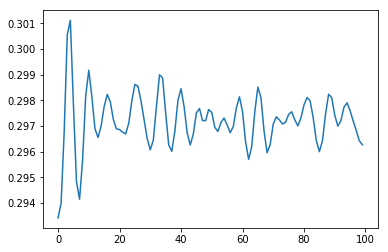

In [49]:
plt.plot(sim1d.energies_total)

Almost every Python plotting package is built on matplotlib, including seaborn (below). matplotlib is very powerful and flexible; unfortunately, that also makes it very finicky. Try changing the formatting below. [You can find documentation here.](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)

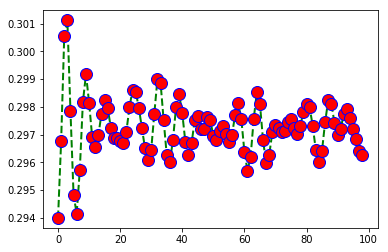

In [50]:
plt.plot(sim1d.energies_total[1:], color='green', marker='o',
        linestyle='dashed', linewidth=2, markersize=12,
        markeredgecolor='blue', markerfacecolor='red')

Seaborn is a library with a smoother interface and documentation. [Here is an example gallery of potential plots you can make.](https://seaborn.pydata.org/examples/index.html) For now we'll make the same line plot as in matplotlib, although Seaborn requires x-values. (This may throw an error if your `energies_total` list is a different length than the number of steps).

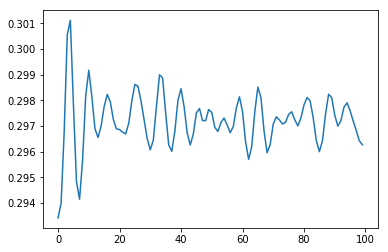

In [51]:
import seaborn as sns
x = list(range(sim1d.n_steps))
sns.lineplot(x, sim1d.energies_total)

One of the best parts about Seaborn is how easy it is to do statistical visualisations. Try plotting a univariate kernel density estimate:

/home/lily/anaconda3/envs/ccpy36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


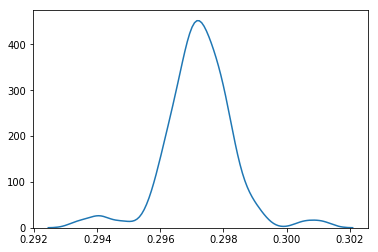

In [52]:
sns.kdeplot(sim1d.energies_total)

Or bivariate:

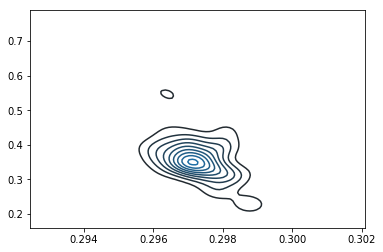

In [53]:
sns.kdeplot(sim1d.energies_total, sim1d.temperatures)

### Averages, standard deviations, etc

There are a few methods to make life easier when analysing data in lists:

In [54]:
avg = sum(sim1d.energies_total)/sim1d.n_steps

Or you could convert it to an array and take advantage of NumPy's many functionalities:

In [56]:
import numpy as np
avg = np.array(sim1d.energies_total).mean()